In [1]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"


opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [2]:
!apt-get update
!apt-get install -y fonts-noto


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]                           
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                                              
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]                                
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [77.5 kB]                 
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,721 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]                             
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,992 kB]                       
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]             
Get:

In [3]:
!pip install torch torchvision transformers opencv-python scikit-learn thop

In [4]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [5]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [6]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import ElectraTokenizer, BertModel
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from thop import profile

In [7]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [8]:
df.head()

,id,caption,label
4677,4678,এ যেন এক সুগন্ধির মহাকাব্য!\nযার পঙক্তিমালায় র...,Non Informative
2042,2043,জন্মদিনে ১২ ফ্লেভারের ৩৬ ইঞ্চি পিৎজা পাবেন,Non Informative
410,411,মংলায় ঝড়ের তাণ্ডবে বিদ্যুতের লাইন বিচ্ছিন্ন,Cyclone
4607,4608,"ফটিকছড়ি, বাংলাদেশের চট্টগ্রাম বিভাগ এর একটি উ...",Non Informative
1483,1484,ফিনল্যান্ডের উপকূলে প্লাস্টিক ও রাসায়নিক বর্জ...,Anthropogenic


In [9]:
# Define label mapping
label_mapping = {
    'River Erosion': 3,
    'Cyclone': 1,
    'Anthropogenic': 4,
    'flood': 0,
    'Earthquake': 2,
    'Non Informative': -1  # Will be filtered out
}

# Apply label mapping and remove 'Non Informative' rows
df['label'] = df['label'].map(label_mapping)
df = df[df['label'] != -1].reset_index(drop=True)

In [10]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [11]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()


In [12]:
# Define the transformations for the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the tokenizer
tokenizer = ElectraTokenizer.from_pretrained('csebuetnlp/banglabert')



tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

In [13]:
# Custom Dataset
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, images_folder, tokenizer, image_transforms):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'anthropogenic': 4
        }
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = str(row['caption'])
        label = int(row['label'])
        image_id = str(row['id']).strip()

        image_path = os.path.join(self.images_folder, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.png")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.jpeg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image {image_id} not found")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)
        text_inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        assert 0 <= label <= 4, f"Label {label} out of range"

        return {
            'input_ids': text_inputs['input_ids'].squeeze(),
            'attention_mask': text_inputs['attention_mask'].squeeze(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'original_label': self.index_to_class[label]
        }

In [14]:
# Create datasets and dataloaders
images_folder = '/kaggle/input/mddb-images/Photos_Final'
train_dataset = MultimodalDataset(train_data, images_folder, tokenizer, image_transforms)
valid_dataset = MultimodalDataset(valid_data, images_folder, tokenizer, image_transforms)
test_dataset = MultimodalDataset(test_data, images_folder, tokenizer, image_transforms)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

1596
532
533


In [16]:
# Define the late fusion model
class LateFusionModel(nn.Module):
    def __init__(self, num_classes=5, bert_model_name='csebuetnlp/banglabert', efficientnet_model='efficientnet_b0'):
        super(LateFusionModel, self).__init__()
        
        # Text branch: BanglaBERT
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.text_fc = nn.Sequential(
            nn.Linear(768, 256),  # BERT output size is 768
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128)   # Reduce to a smaller feature size
        )
        
        # Image branch: EfficientNet
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # Remove original classifier
        self.image_fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128)   # Reduce to a smaller feature size
        )
        
        # Fusion layer: Concatenate text and image features
        self.fusion_fc = nn.Sequential(
            nn.Linear(128 + 128, 64),  # Concatenated size: 128 (text) + 128 (image)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)  # Final classification layer
        )
        
    def forward(self, input_ids, attention_mask, image):
        # Text branch
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output  # [CLS] token embedding
        text_features = self.text_fc(text_features)  # Process text features
        
        # Image branch
        image_features = self.efficientnet(image)  # Extract image features
        image_features = self.image_fc(image_features)  # Process image features
        
        # Late fusion: Concatenate features
        fused_features = torch.cat((text_features, image_features), dim=1)
        output = self.fusion_fc(fused_features)  # Final classification
        
        return output

In [17]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LateFusionModel(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 10
train_losses = []
valid_losses = []
best_valid_loss = float('inf')
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * input_ids.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * input_ids.size(0)

    valid_loss /= len(valid_dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)

# Load best model for evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.lay

Epoch 1/10, Train Loss: 1.6012, Valid Loss: 1.5951


Epoch 2/10: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


Epoch 2/10, Train Loss: 1.5734, Valid Loss: 1.5393


Epoch 3/10: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Epoch 3/10, Train Loss: 1.4305, Valid Loss: 1.2726


Epoch 4/10: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Epoch 4/10, Train Loss: 1.1209, Valid Loss: 0.9338


Epoch 5/10: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


Epoch 5/10, Train Loss: 0.8583, Valid Loss: 0.7598


Epoch 6/10: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Epoch 6/10, Train Loss: 0.6377, Valid Loss: 0.7173


Epoch 7/10: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Epoch 7/10, Train Loss: 0.5137, Valid Loss: 1.0157


Epoch 8/10: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


Epoch 8/10, Train Loss: 0.3817, Valid Loss: 0.4049


Epoch 9/10: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Epoch 9/10, Train Loss: 0.2513, Valid Loss: 0.4265


Epoch 10/10: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Epoch 10/10, Train Loss: 0.2348, Valid Loss: 0.5418


<ipython-input-17-adca9f38660e>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


LateFusionModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi


Test Set Evaluation:
Accuracy: 0.8537
Precision: 0.8613
Recall: 0.8537
F1 Score: 0.8527

Classification Report:
               precision    recall  f1-score   support

        flood       0.92      0.70      0.79       105
      cyclone       0.77      0.91      0.83       101
   earthquake       0.82      0.90      0.86       118
river erosion       0.84      0.83      0.83        86
anthropogenic       0.94      0.92      0.93       123

     accuracy                           0.85       533
    macro avg       0.86      0.85      0.85       533
 weighted avg       0.86      0.85      0.85       533



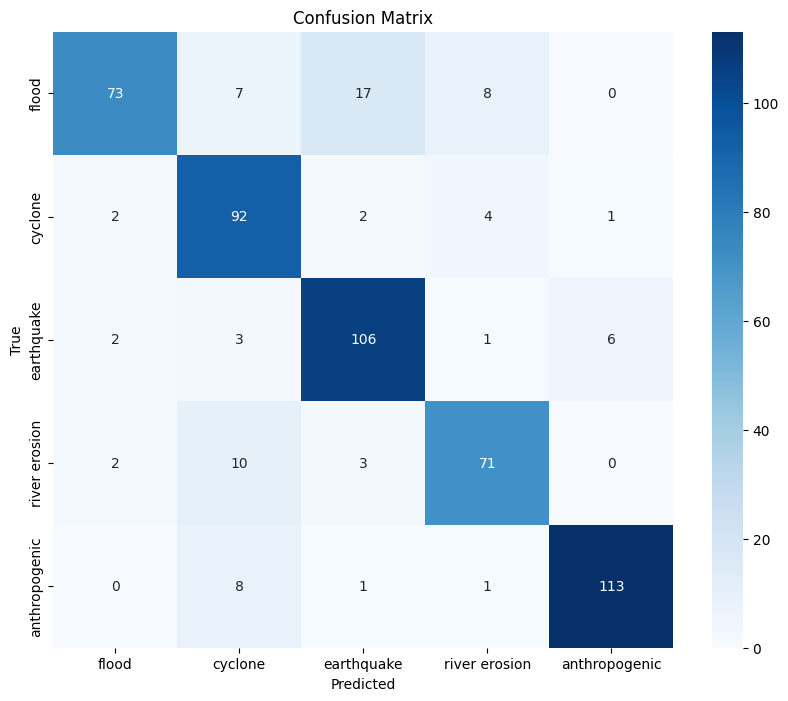

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Evaluation on test set
true_labels = []
pred_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, images)
        _, preds = torch.max(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['flood', 'cyclone', 'earthquake', 'river erosion', 'anthropogenic']))

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['flood', 'cyclone', 'earthquake', 'river erosion', 'anthropogenic'], yticklabels=['flood', 'cyclone', 'earthquake', 'river erosion', 'anthropogenic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

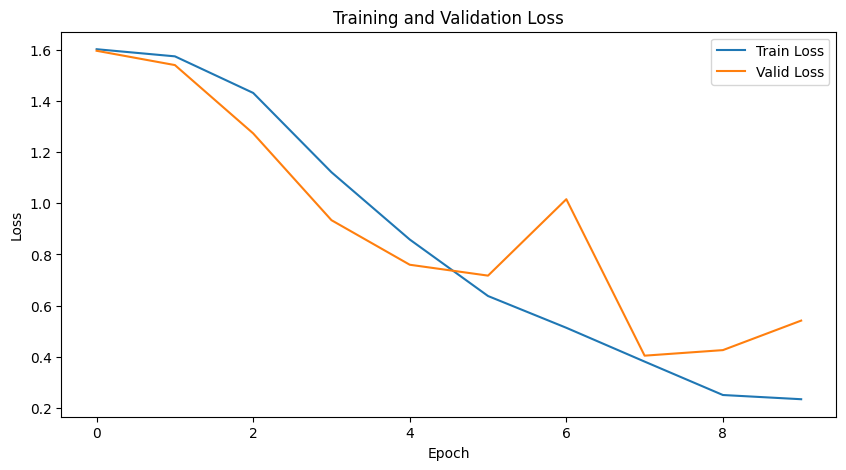

In [19]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [20]:
# Profile the model
dummy_input_ids = torch.randint(0, 1000, (1, 128)).to(device)
dummy_attention_mask = torch.ones(1, 128).to(device)
dummy_image = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(model, inputs=(dummy_input_ids, dummy_attention_mask, dummy_image))
print(f"FLOPs: {flops:.2e}, Parameters: {params:.2e}")

[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
FLOPs: 1.13e+10, Parameters: 9.03e+07


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['অন', 'একট', 'এব', 'কর', 'জন', 'যদ', 'রপর', 'হত', 'হয'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2472 (\N{BENGALI LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2441 (\N{BENGALI LETTER U}) missing from current font.
  fi

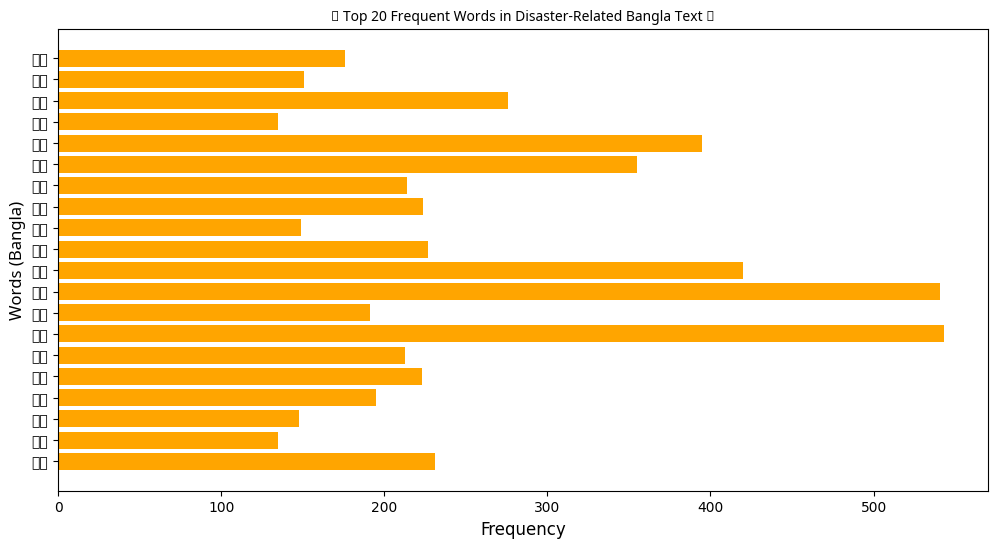

In [21]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.feature_extraction.text import CountVectorizer

bangla_stop_words = ['এবং', 'কিন্তু', 'যদি', 'এই', 'তারপর', 'জন্য', 'একটি', 'কোন', 'সাথে', 'হতে', 'বা', 'তাই', 'যখন', 'তাদের', 'অনেক', 'হয়', 'করেছে']
vectorizer = CountVectorizer(stop_words=bangla_stop_words, max_features=20)
X = vectorizer.fit_transform(df['caption'])
words = vectorizer.get_feature_names_out()
word_count = X.sum(axis=0).A1
word_freq = dict(zip(words, word_count))

# Use a font with Bangla and Latin support
font_path = "/usr/share/fonts/truetype/noto/NotoSans-Regular.ttf"
font_prop = fm.FontProperties(fname=font_path)

plt.figure(figsize=(12, 6))
plt.barh(list(word_freq.keys()), list(word_freq.values()), color='orange')
plt.xlabel('Frequency', fontsize=12)  # English - default font
plt.ylabel('Words (Bangla)', fontsize=12, fontproperties=font_prop)  # Bangla only
plt.title('🔹 Top 20 Frequent Words in Disaster-Related Bangla Text 🔹', fontsize=14, fontproperties=font_prop)  # Mix
plt.gca().invert_yaxis()
plt.show()
